In [2]:
import pandas as pd
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim
import matplotlib.pyplot as plt 
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [3]:
# loading Amazon data (stock history)
amazon_data = pd.read_csv('Amazon_stock_history.csv')

# Filtering required data (Date and Close stock value)
amazon_data_required = amazon_data[["Date", "Close"]]

amazon_data_required


,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
5,1997-05-22,0.069792
6,1997-05-23,0.075000
7,1997-05-27,0.079167
8,1997-05-28,0.076563
9,1997-05-29,0.075260


In [4]:
# GPU connection
device = 'cude:0' if torch.cuda.is_available() else 'cup'

device

'cup'

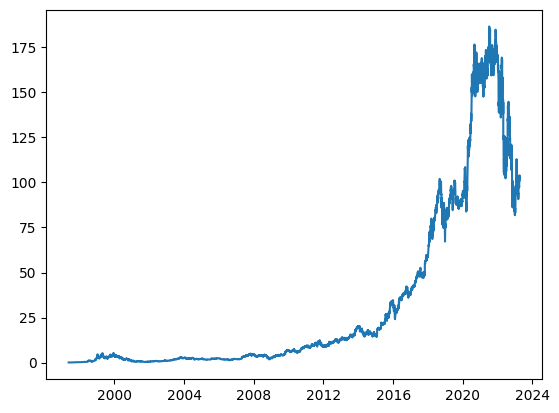

In [5]:
# transformation
amazon_data_required['Date'] = pd.to_datetime(amazon_data_required['Date'])
plt.plot(amazon_data_required['Date'], amazon_data_required['Close'])

In [6]:
# Preparing data for LSTM
def data_prepare_for_processing(amazon_data_required, number_of_steps):
    dc_dataFrame = dc(amazon_data_required)
    dc_dataFrame['Date'] = pd.to_datetime(dc_dataFrame['Date'])

    dc_dataFrame.set_index('Date', inplace = True)

    for step in range(1, number_of_steps+1):
        dc_dataFrame[f'close(t-{step})'] = dc_dataFrame['Close'].shift(step)
    
    dc_dataFrame.dropna(inplace = True)

    return dc_dataFrame

In [7]:
number_of_steps = 7

dataFrame_obtained =  data_prepare_for_processing(amazon_data_required, number_of_steps)

dataFrame_obtained

,Close,close(t-1),close(t-2),close(t-3),close(t-4),close(t-5),close(t-6),close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
1997-06-03,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792
1997-06-04,0.070833,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000
1997-06-05,0.077083,0.070833,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167
1997-06-06,0.082813,0.077083,0.070833,0.073958,0.075521,0.075000,0.075260,0.076563


In [8]:
# Transforming from dataFrame to numpy

# Defining scaler between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))

transforming_dataFrame_to_numpy = scaler.fit_transform(dataFrame_obtained)

transforming_dataFrame_to_numpy


array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [9]:
# Splitting features and predictors

# All colums execpt first 
features = transforming_dataFrame_to_numpy[:, 1:]
# flipping features 
features = dc(np.flip(features, axis=1))
# First colum
predictor = transforming_dataFrame_to_numpy[:, 0]

features.shape, predictor.shape

((6509, 7), (6509,))

In [54]:
# Data splitting for training and testing

# 90% for traing and 10% for testing
splitting_ratio = int(len(features) * 0.90)

training_features = features[:splitting_ratio]
testing_features = features[splitting_ratio:]

training_predictors = predictor[:splitting_ratio]
testing_predictors = predictor[splitting_ratio:]


training_features.shape, testing_features.shape, training_predictors.shape, testing_predictors.shape


((5858, 7), (651, 7), (5858,), (651,))

In [55]:
# Reshaping for Pytorch LSTM

training_features = training_features.reshape((-1, number_of_steps, 1))
testing_features = testing_features.reshape((-1, number_of_steps, 1))

training_predictors = training_predictors.reshape((-1, 1))
testing_predictors = testing_predictors.reshape((-1, 1))

training_features.shape, testing_features.shape, training_predictors.shape, testing_predictors.shape



((5858, 7, 1), (651, 7, 1), (5858, 1), (651, 1))

In [56]:
# converting to pytorch tensors
training_features = torch.tensor(training_features).float()
testing_features = torch.tensor(testing_features).float()

training_predictors = torch.tensor(training_predictors).float()
testing_predictors= torch.tensor(testing_predictors).float()

training_features.shape, testing_features.shape, training_predictors.shape, testing_predictors.shape


(torch.Size([5858, 7, 1]),
 torch.Size([651, 7, 1]),
 torch.Size([5858, 1]),
 torch.Size([651, 1]))

In [57]:
# Making Dataset with custom class

class SequenceDataset(Dataset):
    def __init__(self, features, predictors):
        self.features = features
        self.predictors = predictors

    def __len__(self):
        return len(self.features)

    def __getitem__(self, i):
        return self.features[i], self.predictors[i]
    
training_dataset = SequenceDataset(training_features, training_predictors)
testing_dataset = SequenceDataset(testing_features, testing_predictors)


In [58]:
# Converting dataset into batches with DataLoader

batch_size = 10

# Shuffling training data
training_dataset_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

# Shuffling if off on training data
testing_dataset_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

In [59]:
# Defining Model

class LSTMforPrediction(nn.Module):
    def __init__(self, input_size, hidden, stacked_layers):
        super().__init__()

        #Tuneable parameters
        self.hidden = hidden
        self.stacked_layers = stacked_layers

        # One LSTM layer and one linear layer
        self.lstm_layer_1 = nn.LSTM(input_size, hidden, stacked_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden, 1)
    
    def forward(self, inputs):
        number_of_samples = inputs.size(0)

        #intializing states
        intial_hidden_state = torch.zeros(self.stacked_layers, number_of_samples, self.hidden)
        LSTM_layer_1_self_state = torch.zeros(self.stacked_layers, number_of_samples, self.hidden)

        
        LSTM_layer_1_hidden_state, _ = self.lstm_layer_1(inputs, (intial_hidden_state, LSTM_layer_1_self_state))
        output = self.linear_layer(LSTM_layer_1_hidden_state[:, -1, :])

        return output


In [60]:
model = LSTMforPrediction(1, 4, 1)
model

LSTMforPrediction(
  (lstm_layer_1): LSTM(1, 4, batch_first=True)
  (linear_layer): Linear(in_features=4, out_features=1, bias=True)
)

In [61]:
def train():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    sum_loss = 0.0

    # Training model batch by batch
    for batch_index, batch in enumerate(training_dataset_loader):

        # features and labels of one batch
        features, labels = batch[0],  batch[1]
        
        # predicting through model
        predictions = model(features)
        #calculating loss
        loss = criterion(predictions, labels)
        sum_loss += loss.item()

        # optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # prining loss after 50 batches
        if (batch_index % 50 == 49):
            print('Batch {0}, Loss: {1: 3f}'.format(batch_index+1, sum_loss/50))

            sum_loss = 0.0



In [62]:
def test():
    model.train(False)
    sum_loss = 0.0

    # Testing model batch by batch
    for batch_index, batch in enumerate(testing_dataset_loader):

        # features and labels of one batch
        features, labels = batch[0],  batch[1]

        with torch.no_grad():
            predictions = model(features)
            loss = criterion(predictions, labels)
            sum_loss += loss.item()
    
    print(' \n Testing Loss: {0:.3f}'.format(sum_loss / len(testing_dataset_loader)))
    print('------------------------- \n')


In [63]:

# tuneable parameter

epochs = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)
# Model training and Testing
for epoch in range(epochs):
    train()
    test()


Epoch: 1
Batch 50, Loss:  0.179295
Batch 100, Loss:  0.022105
Batch 150, Loss:  0.002634
Batch 200, Loss:  0.002829
Batch 250, Loss:  0.000503
Batch 300, Loss:  0.002924
Batch 350, Loss:  0.000736
Batch 400, Loss:  0.002201
Batch 450, Loss:  0.001218
Batch 500, Loss:  0.000615
Batch 550, Loss:  0.000811
 
 Testing Loss: 0.024
------------------------- 

Epoch: 2
Batch 50, Loss:  0.000341
Batch 100, Loss:  0.000355
Batch 150, Loss:  0.000241
Batch 200, Loss:  0.000203
Batch 250, Loss:  0.000115
Batch 300, Loss:  0.000185
Batch 350, Loss:  0.000115
Batch 400, Loss:  0.000114
Batch 450, Loss:  0.000100
Batch 500, Loss:  0.000104
Batch 550, Loss:  0.000099
 
 Testing Loss: 0.003
------------------------- 

Epoch: 3
Batch 50, Loss:  0.000097
Batch 100, Loss:  0.000108
Batch 150, Loss:  0.000066
Batch 200, Loss:  0.000083
Batch 250, Loss:  0.000078
Batch 300, Loss:  0.000078
Batch 350, Loss:  0.000085
Batch 400, Loss:  0.000121
Batch 450, Loss:  0.000142
Batch 500, Loss:  0.000163
Batch 550,

In [70]:
# Tranforming data back to original close values
predicted_close = model(testing_features).detach().numpy().flatten()

# Prediction Results on Test Data
reshape = np.zeros((testing_features.shape[0], number_of_steps+1))
reshape[:, 0] = predicted_close
reshape = scaler.inverse_transform(reshape)
predicted_close = dc(reshape[:, 0])

# Actual Lables on Test Data
reshape = np.zeros((testing_features.shape[0], number_of_steps+1))
reshape[:, 0] = testing_predictors.flatten()
reshape = scaler.inverse_transform(reshape)
actual_close = dc(reshape[:, 0])




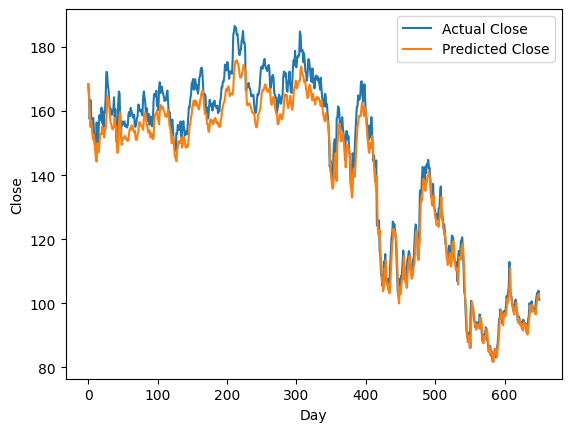

In [71]:
# Disply the difference between prediction and actual close values
plt.plot(actual_close, label='Actual Close')
plt.plot(predicted_close, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()